<center>
    
# Twitter Analysis
    
Student Number: 2021029 - Joyce Simiao
    
 </center>

In [1]:
#Importing necessary libraries
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
from pymongo import MongoClient
from textblob import TextBlob
from wordcloud import WordCloud
import re
from unidecode import unidecode
from string import punctuation
import ipywidgets as widgets
from IPython.display import clear_output

## Reading File

In [2]:
# Reading file and adding name of the columns
column_names = ['Twitter_Id', 'Date', 'Query', 'Users', 'Tweet']
data = pd.read_csv('ProjectTweets.csv', names = column_names)
data.head()

,Twitter_Id,Date,Query,Users,Tweet
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Twitter_Id  1600000 non-null  int64 
 1   Date        1600000 non-null  object
 2   Query       1600000 non-null  object
 3   Users       1600000 non-null  object
 4   Tweet       1600000 non-null  object
dtypes: int64(1), object(4)
memory usage: 73.2+ MB


## Data cleaning

In [4]:
# Function to clean dataset
def data_cleaning():
    print(data.head())

    # Handle Missing Values
    missing_values = data.isnull().sum()
    print("Missing Values:\n", missing_values)

    # Handling Duplicates
    data.drop_duplicates(inplace=True)
    
data_cleaning()
   


   Twitter_Id                          Date     Query            Users  \
0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                               Tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  
Missing Values:
 Twitter_Id    0
Date          0
Query         0
Users         0
Tweet         0
dtype: int64


In [5]:
# checking information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1598315 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Twitter_Id  1598315 non-null  int64 
 1   Date        1598315 non-null  object
 2   Query       1598315 non-null  object
 3   Users       1598315 non-null  object
 4   Tweet       1598315 non-null  object
dtypes: int64(1), object(4)
memory usage: 73.2+ MB


In [6]:
# Function to clean text
def cleanTxt(text):
    text = re.sub('@[A-Za-z0-9]+', '', text)
    # Putting all letters in lower case
    text = text.lower()
    # Excluding @
    text = re.sub('@[^\s]+', '', text)
    # Excluding acent
    #text = unidecode(text)
    # Excluding html tags such as <strong></strong>
    text = re.sub('<[^<]+?>','', text)
    # Excluding numbers:
    text = ''.join(c for c in text if not c.isdigit())
    # Excluding URL's:
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    # Excluding punctuation 
    text = ''.join(c for c in text if c not in punctuation)
    return text

In [7]:
# Applying function above to clean the text from both files
data['Tweet']= data['Tweet'].apply(cleanTxt)

In [8]:
data.head()

,Twitter_Id,Date,Query,Users,Tweet
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david ...
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sa...
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i he...


In [9]:
# Using VADER for sentiment  
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
sia

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\joyce\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Sentiment Analysis

In [10]:
def calculate_sentiment(text):
    sentiment_scores = sia.polarity_scores(str(text))
    sentiment = ""
    if sentiment_scores["compound"] >= 0.05:
        sentiment = "positive"
    elif sentiment_scores["compound"] <= -0.05:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment

tweet_column_index = 4
data["sentiment"] = data.iloc[:, tweet_column_index].apply(calculate_sentiment)
#data.to_csv("sentiment_analysis_results.csv", index=False)


In [11]:
data.head()

,Twitter_Id,Date,Query,Users,Tweet,sentiment
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david ...,negative
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,negative
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sa...,positive
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,negative
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i he...,negative


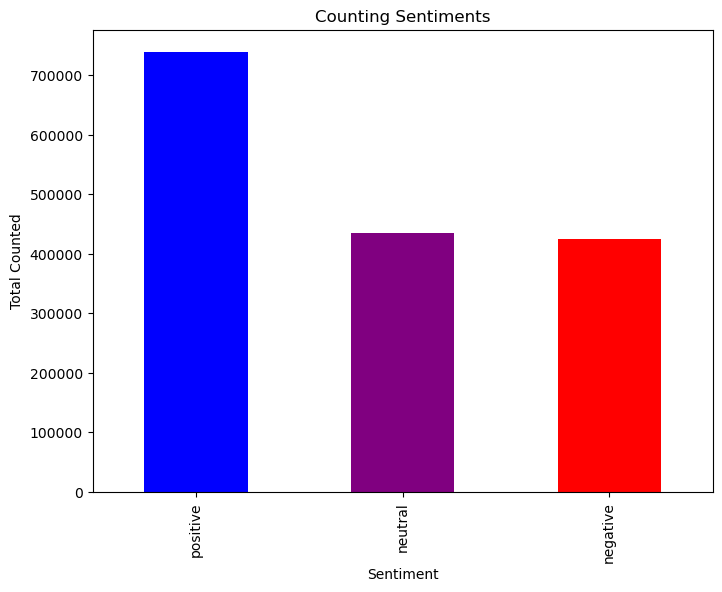

In [12]:
# Counting Sentiment
sentiment_counts = data['sentiment'].value_counts()

# Ploting Graphic
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['blue', 'purple', 'red'])
plt.title('Counting Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Total Counted')
plt.show()



## Most used words

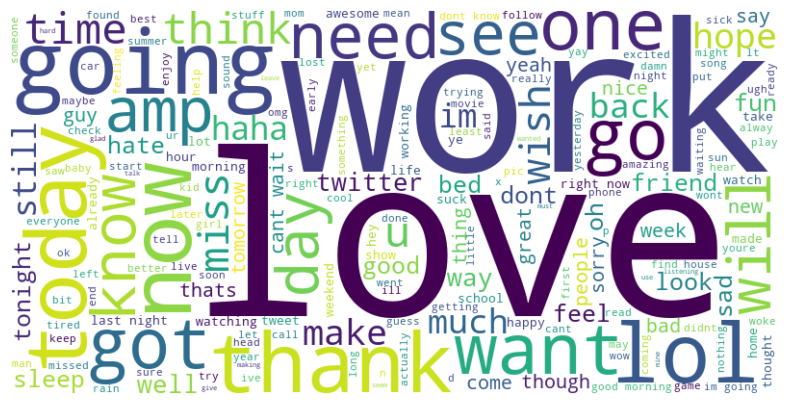

In [13]:
# Combining all tweets e in one unique string
text = ' '.join(data['Tweet'].astype(str))

# WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Plotting Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Counting Users

In [14]:
# Counting Userrs
count_users = data['Users'].value_counts()

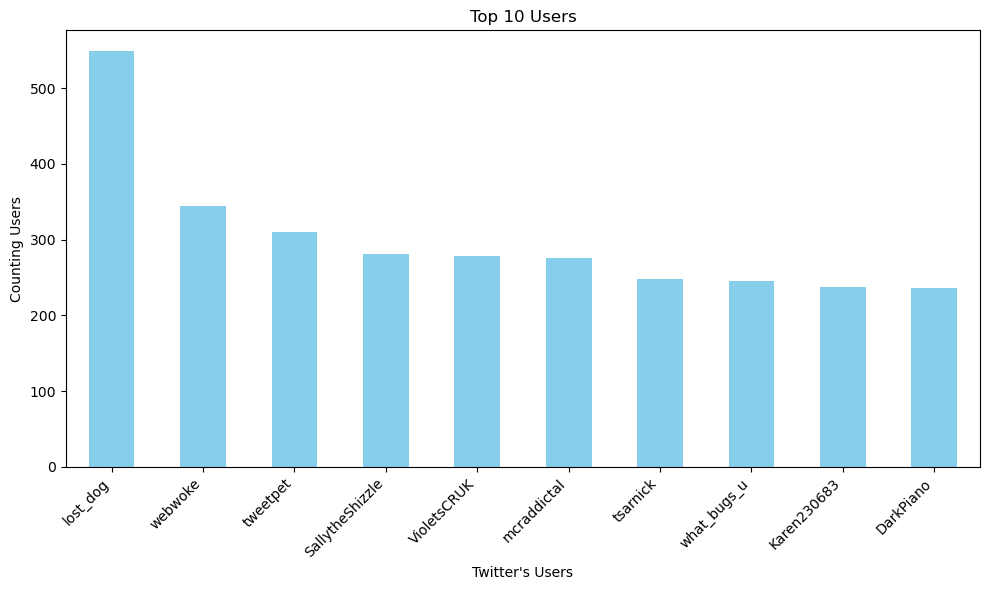

In [15]:
# selecting the 10 users who contributed the most
top_n = 10
top_users = count_users.head(top_n)

# Plotting
plt.figure(figsize=(10, 6))
top_users.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Users')
plt.xlabel("Twitter's Users")
plt.ylabel('Counting Users')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [16]:
# Convert 'timestamp' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


C:\Users\joyce\anaconda3\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


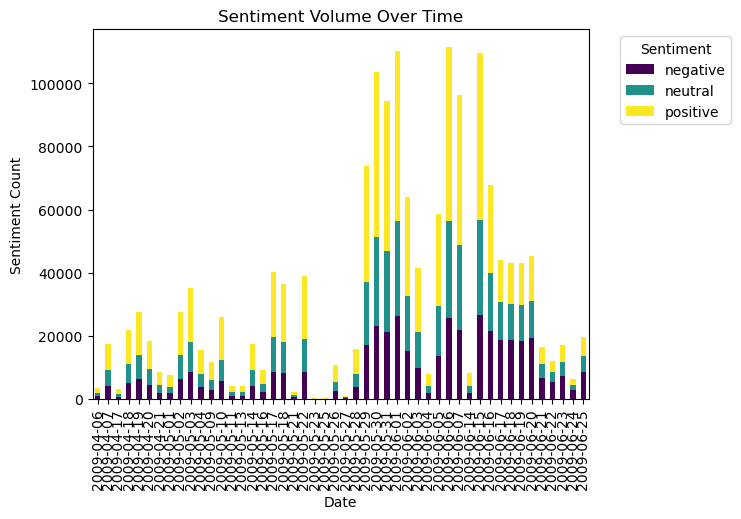

In [17]:
# Group by date and count the sentiment occurrences
sentiment_counts = data.groupby(data['Date'].dt.date)['sentiment'].value_counts().unstack().fillna(0)

# Plotting
sentiment_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Sentiment Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1598315 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Twitter_Id  1598315 non-null  int64         
 1   Date        1598315 non-null  datetime64[ns]
 2   Query       1598315 non-null  object        
 3   Users       1598315 non-null  object        
 4   Tweet       1598315 non-null  object        
 5   sentiment   1598315 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 85.4+ MB


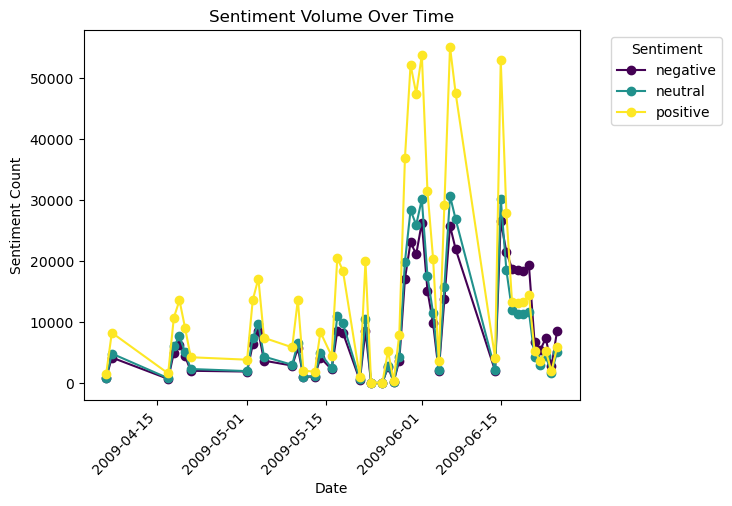

In [19]:
sentiment_counts.plot(kind='line', marker='o', colormap='viridis')
plt.title('Sentiment Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45, ha='right') 
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

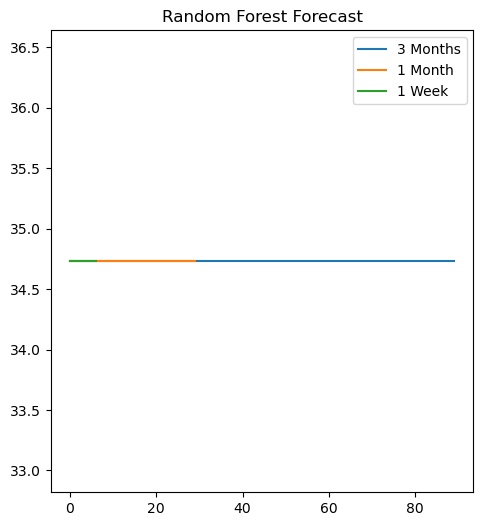

In [37]:
# Splitting data with ARIMA, plotting 1 week, 1 month, 3 months
data['y'] = data['Tweet'].str.len()


if 0 < len(data) < 1e6:
    data_sample = data.sample(frac=0.1)
    model_arima = ARIMA(data_sample['y'], order=(5, 1, 0))
    model_fit_arima = model_arima.fit()
    forecast_arima_week = model_fit_arima.forecast(steps=7)
    forecast_arima_month = model_fit_arima.forecast(steps=30)
    forecast_arima_3months = model_fit_arima.forecast(steps=90)
    
if len(data) > 0:
    X = np.array(range(len(data))).reshape(-1, 1)
    y = data['y']
    model_rf = RandomForestRegressor(n_estimators=100)
    model_rf.fit(X, y)
    future_week = np.array(range(len(data), len(data) + 7)).reshape(-1, 1)
    future_month = np.array(range(len(data), len(data) + 30)).reshape(-1, 1)
    future_3months = np.array(range(len(data), len(data) + 90)).reshape(-1, 1)
    forecast_rf_week = model_rf.predict(future_week)
    forecast_rf_month = model_rf.predict(future_month)
    forecast_rf_3months = model_rf.predict(future_3months)
    
else:
    print("The DataFrame is empty.")
    
plt.figure(figsize=(12, 6))

if 'forecast_arima_week' in locals():
    plt.subplot(1, 2, 1)
    plt.title('ARIMA Forecast')
    plt.plot(forecast_arima_3months, label='3 Months')
    plt.plot(forecast_arima_month, label='1 Month')
    plt.plot(forecast_arima_week, label='1 Week')
    plt.legend()

if 'forecast_rf_week' in locals():
    plt.subplot(1, 2, 2)
    plt.title('Random Forest Forecast')
    plt.plot(forecast_rf_3months, label='3 Months')
    plt.plot(forecast_rf_month, label='1 Month')
    plt.plot(forecast_rf_week, label='1 Week')
    plt.legend()

plt.show()

In [21]:
app = dash.Dash(__name__)

#df = pd.read_csv('sentiment_results.csv')
#data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data_count = data.groupby([pd.Grouper(key='Date', freq='H'), 'sentiment']).size().reset_index(name='count')

app.layout = html.Div([
    html.H1("Tweet Sentiments Over Time"),

    dcc.Dropdown(
        id='sentiment-dropdown',
        options=[
            {'label': 'Positive', 'value': 'positive'},
            {'label': 'Negative', 'value': 'negative'},
            {'label': 'Neutral', 'value': 'neutral'},
            {'label': 'All', 'value': 'all'}
        ],
        value='all',  # Default value
        multi=False
    ),

    dcc.Graph(id='line-plot'),
])

@app.callback(
    Output('line-plot', 'figure'),
    [Input('sentiment-dropdown', 'value')]
)
def update_graph(selected_sentiment):
    if selected_sentiment == 'all':
        fig = px.line(data_count, x='Date', y='count', color='sentiment', title='All Sentiments Over Time')
    else:
        filtered_data = data_count[data_count['sentiment'] == selected_sentiment]
        fig = px.line(filtered_data, x='Date', y='count', title=f'{selected_sentiment.capitalize()} Sentiments Over Time')

    return fig

if __name__ == "__main__":
    #app.run_server(debug=True)
    app.run_server(port=2223)

## Mongo DB

In [22]:
# Define the MongoDB connection
client = MongoClient('localhost', 27017)
db = client['sentiment_analysis_db']
collection = db['sentiment_results']

# Read the sentiment analysis results from the CSV file
sentiment_results = pd.read_csv('sentiment_analysis_results.csv')

# Convert the dataframe to a dictionary
data_dict = sentiment_results.to_dict("records")

# Insert the data into the MongoDB collection
collection.insert_many(data_dict)

# Display success message
print("Sentiment analysis results successfully saved to MongoDB.")

Sentiment analysis results successfully saved to MongoDB.


## Random Forest

In [23]:
# Importing Dataset
data2 = pd.read_csv('sentiment_results_test.csv')
data2.head()

,Twitter_Id,Date,Query,Users,Tweet,sentiment
0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david ...,negative
1,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,negative
2,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,i dived many times for the ball managed to sa...,positive
3,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,negative
4,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,no its not behaving at all im mad why am i he...,negative


In [24]:
# Dropping Columns
data2 = data2.drop(['Twitter_Id', 'Query'], axis=1)

# Changing the column Date into DateTime
data2['Date'] = pd.to_datetime(data2['Date'])

In [25]:
# Checking info of the dataset
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598315 entries, 0 to 1598314
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   Date       1598315 non-null  datetime64[ns]
 1   Users      1598315 non-null  object        
 2   Tweet      1598315 non-null  object        
 3   sentiment  1598315 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 48.8+ MB


In [26]:
# Splitting column Data to year, Month, day
data2['year'] = data2['Date'].dt.year
data2['Month'] = data2['Date'].dt.month
data2['Day'] = data2['Date'].dt.day

In [27]:
# Creating columns to count words and mean on the Tweet column
data2['Number_Words'] = data2.Tweet.apply(lambda x:len(x.split(' ')))
data2['Mean_Word_Len'] = data2.Tweet.apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )
data2.head()

,Date,Users,Tweet,sentiment,year,Month,Day,Number_Words,Mean_Word_Len
0,2009-04-06 22:19:45,_TheSpecialOne_,awww thats a bummer you shoulda got david ...,negative,2009,4,6,20,2.75
1,2009-04-06 22:19:49,scotthamilton,is upset that he cant update his facebook by t...,negative,2009,4,6,22,3.82
2,2009-04-06 22:19:53,mattycus,i dived many times for the ball managed to sa...,positive,2009,4,6,19,3.05
3,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,negative,2009,4,6,11,3.36
4,2009-04-06 22:19:57,Karoli,no its not behaving at all im mad why am i he...,negative,2009,4,6,22,3.00


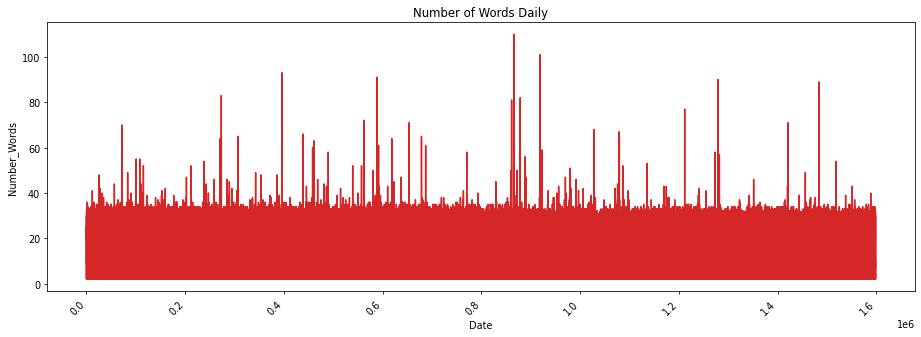

In [28]:
# Plotting
def plot_df(data2, x, y, title="", xlabel='Date', ylabel='Number_Words', dpi=70):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xticks(rotation=45, ha='right')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data2, x=data2.index, y=data2.Number_Words, title='Number of Words Daily') 

In [29]:
#Creating lag features
data2['lag_1week'] = data2['Number_Words'].shift(7)  # 1 week lag
data2['lag_1month'] = data2['Number_Words'].shift(30)  # 1 month lag 
data2['lag_3months'] = data2['Number_Words'].shift(90)  # 3 months lag 

In [30]:
# Cleaning missing values
data2 = data2.dropna()

In [31]:
data2.head()

,Date,Users,Tweet,sentiment,year,Month,Day,Number_Words,Mean_Word_Len,lag_1week,lag_1month,lag_3months
90,2009-04-06 22:26:10,RU_it_girl,i should have paid more attention when we cov...,neutral,2009,4,6,19,4.37,5.0,19.0,20.0
91,2009-04-06 22:26:14,viviana09,wednesday my bday dont know what do,neutral,2009,4,6,9,3.22,11.0,8.0,22.0
92,2009-04-06 22:26:18,disneyfan4eva,poor cameron the hills,negative,2009,4,6,5,3.80,23.0,9.0,19.0
93,2009-04-06 22:26:21,RoseMaryK,pray for me please the ex is threatening to st...,positive,2009,4,6,27,3.74,10.0,18.0,11.0
94,2009-04-06 22:26:22,perrohunter,hmm do u really enjoy being with him if th...,positive,2009,4,6,27,3.52,24.0,16.0,22.0


In [32]:
# Split the data into training and testing sets
train_size = int(len(data2) * 0.8)
train, test = data2[0:train_size], data2[train_size:]

# Features and target variable
X_train, y_train = train[['lag_1week', 'lag_1month', 'lag_3months']], train['Number_Words']
X_test, y_test = test[['lag_1week', 'lag_1month', 'lag_3months']], test['Number_Words']

In [33]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Train a model (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# predictions
y_pred = model.predict(X_test_scaled)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 49.097985382971146


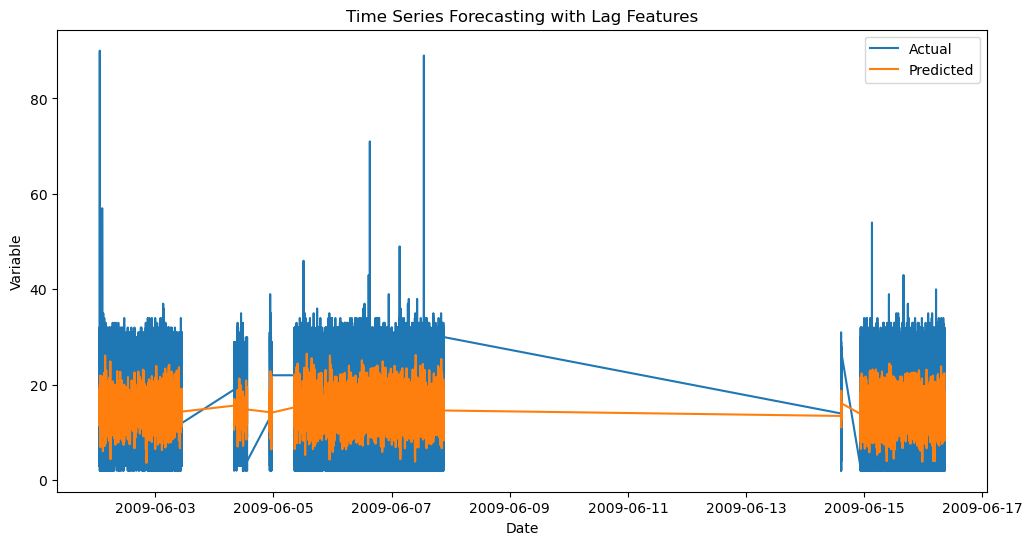

In [35]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Variable')
plt.title('Time Series Forecasting with Lag Features')
plt.legend()
plt.show()

In [46]:
from functools import reduce

# Função de mapeamento
def mapper(item):
    # A função de mapeamento processa um item e emite uma lista de pares (chave, valor)
    # Neste exemplo, a chave é a palavra e o valor é 1
    words = item.split()
    return [(word, 1) for word in words]

# Função de redução
def reducer(item1, item2):
    # A função de redução soma os valores para cada chave
    return item1 + item2

# Função principal de MapReduce
def mapreduce(data):
    # Mapeamento
    mapped_data = map(mapper, data)
    # Achatamento da lista
    flattened_data = [item for sublist in mapped_data for item in sublist]
    # Ordenação por chave (opcional)
    flattened_data.sort(key=lambda x: x[0])
    # Redução
    reduced_data = reduce(reducer, flattened_data)
    return reduced_data

# Exemplo de dados

data = pd.read_csv('ProjectTweets.csv', names = column_names)

# Executar o MapReduce nos dados
result = mapreduce(data)

# Imprimir resultado
print(result)

('Date', 1, 'Query', 1, 'Tweet', 1, 'Twitter_Id', 1, 'Users', 1)


In [47]:
import pandas as pd
from functools import reduce

# Função de mapeamento
def mapper(item):
    words = item.split()
    return [(word, 1) for word in words]

# Função de redução
def reducer(item1, item2):
    return item1 + item2

# Função principal de MapReduce
def mapreduce(data):
    mapped_data = map(mapper, data)
    flattened_data = [item for sublist in mapped_data for item in sublist]
    flattened_data.sort(key=lambda x: x[0])
    reduced_data = reduce(reducer, flattened_data)
    return reduced_data

df= pd.read_csv('ProjectTweets.csv', names = column_names)

# Obter os valores da coluna "frase"
data = df['Tweet'].tolist()

# Executar o MapReduce nos dados
result = mapreduce(data)

# Imprimir resultado
print(result)



KeyboardInterrupt



In [48]:
from pyspark.sql import SparkSession

In [49]:
spark = SparkSession.builder.getOrCreate()
spark

In [52]:
file_path = 'ProjectTweets.csv'
file = spark.read.csv(file_path, header=True)
file.show()

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [55]:
df = spark.read.csv('ProjectTweets.csv', header = False)
df.printSchema

<bound method DataFrame.printSchema of DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string]>

In [56]:
from pyspark.sql.types import StructType, StructField, StringType, DataType 
custom_schema = StructType([
    StructField("id", StringType(), True),
    StructField("twitter_Id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("query", StringType(), True),
    StructField("users", StringType(), True),
    StructField("tweet", StringType(), True)
])

In [57]:
df = df.withColumnRenamed('_c0','ind').withColumnRenamed('_c1', 'Id').withColumnRenamed('_c2','date').withColumnRenamed('_c3','query').withColumnRenamed('_c4','users').withColumnRenamed('_c5','tweet').show()


+---+----------+--------------------+--------+---------------+--------------------+
|ind|        Id|                date|   query|          users|               tweet|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [58]:
df.createOrReplaceTempView('file')
query_file = "SELECT * FROM file LIMIT 10"

AttributeError: 'NoneType' object has no attribute 'createOrReplaceTempView'

In [45]:
query10 = spark.sql(query_file)
query10_df = query10.toPandas()
query10.show()

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell